## Goal: determine if novel exons have higher Fsts than known exons (both test 5/3 vs. known and novel vs. known separately)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot
import math


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [9]:
df = pd.read_csv(proc_cfg(config['lr']['exons_pop_spec_ss_fsts_summary'], od),
                 sep='\t')

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

3769828
2299334


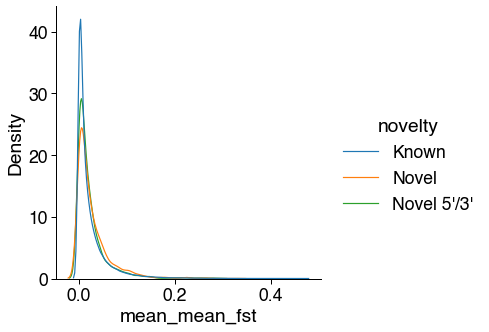

<Figure size 360x360 with 0 Axes>

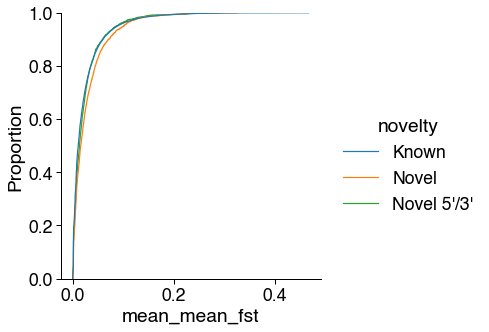

3844
Novel 5'/3' vs. Known:
193058641.5
5.7056107783194935e-09

2876
Novel vs. Known:
153800851.5
1.7635087057448759e-29



<Figure size 360x360 with 0 Axes>

In [10]:
# for each combination of exon and variant position, get the mean FST
# (which will be the mean between the contrasts)
gb_cols = ['eid', 'novelty', 'pop_spec', 'pop_spec_pop', # exon id stuff
           'End_b', 'Start_b'] # var. pos. stuff
keep_cols = gb_cols+['fst']
df = df[keep_cols].groupby(gb_cols).mean().reset_index().rename({'fst':'mean_fst'}, axis=1)

# make sure we have no dupe eid / var. pos. combos
assert len(df.index) == len(df[['eid', 'End_b', 'Start_b']].drop_duplicates().index)

# now also take the mean-mean fst across all variant positions for each exon
gb_cols = ['eid', 'novelty', 'pop_spec', 'pop_spec_pop']
keep_cols = gb_cols+['mean_fst']
df = df[keep_cols].groupby(gb_cols).mean().reset_index().rename({'mean_fst':'mean_mean_fst'}, axis=1)


# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_mean_fst',
            hue='novelty',
            kind='kde',
            common_norm=False)  
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_mean_fst',
            hue='novelty',
            kind='ecdf') 
plt.show()
plt.clf()

for nov in ["Novel 5'/3'", 'Novel']:


    x = df.loc[df.novelty==nov,'mean_mean_fst'].tolist() # hyp. --> greater
    print(len(x))
    y = df.loc[df.novelty=='Known','mean_mean_fst'].tolist()

    # print(f'{pop1} vs {pop2}')
    # print(temp.loc[temp.thing2=='unique','fst'].median())
    # print(temp.loc[temp.thing2=='shared','fst'].median())
    # print()

    print(f'{nov} vs. Known:')
    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    print(stat)
    print(pval)
    print()